In [7]:
import pandas as pd

# Load the dataset
file_path = 'hotel_booking_data_cleaned.csv'  # Update with the correct path to your file
hotel_data = pd.read_csv(file_path)

# List of columns to delete
columns_to_delete = [
    'adults', 'children', 'babies', 'meal', 'country', 'market_segment',
    'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
    'previous_bookings_not_canceled', 'booking_changes', 'deposit_type', 'agent', 'company',
    'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces',
    'total_of_special_requests'
]

# Drop the specified columns from the dataset if they exist
columns_to_delete = [col for col in columns_to_delete if col in hotel_data.columns]
hotel_data_cleaned = hotel_data.drop(columns=columns_to_delete)

# Corrected column names for better readability
corrected_column_names = {
    'hotel': 'Hotel',
    'is_canceled': 'Is_Canceled',
    'lead_time': 'Lead_Time',
    'arrival_date_year': 'Arrival_Year',
    'arrival_date_month': 'Arrival_Month',
    'arrival_date_week_number': 'Arrival_Week_Number',
    'arrival_date_day_of_month': 'Arrival_Day',
    'stays_in_weekend_nights': 'Weekend_Nights',
    'stays_in_week_nights': 'Week_Nights',
    'reserved_room_type': 'Reserved_Room_Type',
    'assigned_room_type': 'Assigned_Room_Type',
    'reservation_status': 'Reservation_Status',
    'reservation_status_date': 'Reservation_Status_Date'
}

# Rename the columns using corrected names
hotel_data_cleaned.rename(columns=corrected_column_names, inplace=True)

# Save the cleaned dataset
hotel_data_cleaned.to_csv('hotel_booking_data_cleaned.csv', index=False)

# Display the first few rows of the cleaned dataset to verify the changes
print(hotel_data_cleaned.head())


          Hotel  Is_Canceled  Lead_Time  Arrival_Year Arrival_Month  \
0  Resort Hotel            0        342          2015          July   
1  Resort Hotel            0        737          2015          July   
2  Resort Hotel            0          7          2015          July   
3  Resort Hotel            0         13          2015          July   
4  Resort Hotel            0         14          2015          July   

   Arrival_Week_Number  Arrival_Day  Weekend_Nights  Week_Nights  \
0                   27            1               0            0   
1                   27            1               0            0   
2                   27            1               0            1   
3                   27            1               0            1   
4                   27            1               0            2   

  Reserved_Room_Type Assigned_Room_Type Reservation_Status  \
0                  C                  C          Check-Out   
1                  C                  C 

In [8]:
unique_hotels = hotel_data_cleaned['Hotel'].unique()
unique_room_types = hotel_data_cleaned['Reserved_Room_Type'].unique()

# Split the data by hotel and room type and save to different files
for hotel in unique_hotels:
    hotel_data = hotel_data_cleaned[hotel_data_cleaned['Hotel'] == hotel]
    for room_type in unique_room_types:
        room_data = hotel_data[hotel_data['Reserved_Room_Type'] == room_type]
        file_name = f'hotel_booking_data_{hotel}_{room_type}.csv'
        room_data.to_csv(file_name, index=False)

print(f"Data for each hotel and room type has been saved into separate CSV files.")


Data for each hotel and room type has been saved into separate CSV files.


In [14]:
import pandas as pd
import datetime

# Load your cleaned dataset
file_path = 'hotel_booking_data_cleaned_v3.csv'  # Update with the correct path to your file
hotel_data_cleaned = pd.read_csv(file_path)

# Filter data for 'Resort Hotel' using .loc to avoid SettingWithCopyWarning
resort_hotel_data = hotel_data_cleaned.loc[hotel_data_cleaned['Hotel'] == 'Resort Hotel'].copy()

# Convert Arrival_Year, Arrival_Day to integers
resort_hotel_data.loc[:, 'Arrival_Year'] = resort_hotel_data['Arrival_Year'].astype(int)
resort_hotel_data.loc[:, 'Arrival_Day'] = resort_hotel_data['Arrival_Day'].astype(int)

# Convert Arrival_Month from month names to numerical values
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}
resort_hotel_data.loc[:, 'Arrival_Month'] = resort_hotel_data['Arrival_Month'].map(month_mapping)

# Function to get arrival date from year, month, day columns
def get_arrival_date(row):
    return datetime.datetime(row['Arrival_Year'], row['Arrival_Month'], row['Arrival_Day'])

# Add a column for the arrival date
resort_hotel_data.loc[:, 'Arrival_Date'] = resort_hotel_data.apply(get_arrival_date, axis=1)

# Calculate the departure date by adding the stay duration
resort_hotel_data.loc[:, 'Departure_Date'] = resort_hotel_data['Arrival_Date'] + pd.to_timedelta(resort_hotel_data['Weekend_Nights'] + resort_hotel_data['Week_Nights'], unit='D')

# Create an empty DataFrame to record daily occupancy for Type A rooms
date_range = pd.date_range(start=resort_hotel_data['Arrival_Date'].min(), end=resort_hotel_data['Departure_Date'].max())
daily_occupancy = pd.DataFrame(date_range, columns=['Date'])
daily_occupancy['Assigned_Type_A_Count'] = 0
daily_occupancy['Reserved_Type_A_Count'] = 0

# Calculate occupancy for assigned Type A rooms
for index, row in resort_hotel_data[resort_hotel_data['Assigned_Room_Type'] == 'A'].iterrows():
    # Mark the occupancy for each day the room is occupied
    daily_occupancy.loc[(daily_occupancy['Date'] >= row['Arrival_Date']) & (daily_occupancy['Date'] < row['Departure_Date']), 'Assigned_Type_A_Count'] += 1

# Calculate occupancy for reserved Type A rooms
for index, row in resort_hotel_data[resort_hotel_data['Reserved_Room_Type'] == 'A'].iterrows():
    # Mark the reservation for each day the room is reserved
    daily_occupancy.loc[(daily_occupancy['Date'] >= row['Arrival_Date']) & (daily_occupancy['Date'] < row['Departure_Date']), 'Reserved_Type_A_Count'] += 1

# Save the result to CSV file
daily_occupancy.to_csv('daily_type_a_occupancy.csv', index=False)

# Display the first few rows of the summary to verify
print(daily_occupancy.head())



        Date  Assigned_Type_A_Count  Reserved_Type_A_Count
0 2015-07-01                     11                     18
1 2015-07-02                     18                     26
2 2015-07-03                     26                     36
3 2015-07-04                     39                     49
4 2015-07-05                     50                     64


In [20]:
import pandas as pd

# Create an empty DataFrame to record daily occupancy for Type A rooms
date_range = pd.date_range(start=resort_hotel_data_filtered['Arrival_Date'].min(), end=resort_hotel_data_filtered['Departure_Date'].max())
daily_occupancy = pd.DataFrame(date_range, columns=['Date'])
daily_occupancy['Assigned_Type_A_Count'] = 0
daily_occupancy['Reserved_Type_A_Count'] = 0

# Calculate occupancy for assigned Type A rooms
for index, row in resort_hotel_data_filtered[resort_hotel_data_filtered['Assigned_Room_Type'] == 'A'].iterrows():
    # Adjust the occupancy range: from Arrival Date to one day before the Departure Date (exclusive of check-out day)
    daily_occupancy.loc[(daily_occupancy['Date'] >= row['Arrival_Date']) & (daily_occupancy['Date'] < row['Departure_Date']), 'Assigned_Type_A_Count'] += 1

# Calculate occupancy for reserved Type A rooms
for index, row in resort_hotel_data_filtered[resort_hotel_data_filtered['Reserved_Room_Type'] == 'A'].iterrows():
    # Adjust the reservation range: from Arrival Date to one day before the Departure Date (exclusive of check-out day)
    daily_occupancy.loc[(daily_occupancy['Date'] >= row['Arrival_Date']) & (daily_occupancy['Date'] < row['Departure_Date']), 'Reserved_Type_A_Count'] += 1

# Save the result to CSV file
daily_occupancy.to_csv('daily_type_a_occupancy_corrected.csv', index=False)

# Display the first few rows of the summary to verify
print(daily_occupancy.head())


        Date  Assigned_Type_A_Count  Reserved_Type_A_Count
0 2015-07-01                     11                     18
1 2015-07-02                     18                     26
2 2015-07-03                     26                     36
3 2015-07-04                     39                     49
4 2015-07-05                     50                     64


In [28]:
import pandas as pd

# Filter data for Type A reservations in Resort Hotel without excluding canceled reservations
type_a_reservations_all = resort_hotel_data[resort_hotel_data['Reserved_Room_Type'] == 'A']

# Prepare a new DataFrame with specific columns required
reservation_dtype_all = pd.DataFrame({
    'Type': [True] * len(type_a_reservations_all),
    # Calculate Reservation Day as Check-in Day minus Lead Time and convert to datetime
    'Reservation Day': (pd.to_datetime(type_a_reservations_all['Arrival_Date'], dayfirst=True) - pd.to_timedelta(type_a_reservations_all['Lead_Time'], unit='D')).dt.date,
    'Check-in Day': pd.to_datetime(type_a_reservations_all['Arrival_Date'], dayfirst=True).dt.date,
    'Occupancy_duration': (type_a_reservations_all['Departure_Date'] - type_a_reservations_all['Arrival_Date']).dt.days,
    'Decision': [1 if status != 'Canceled' else 0 for status in type_a_reservations_all['Reservation_Status']],
    # Add Cancel Date, with value equal to Reservation_Status_Date for canceled reservations and NaN otherwise
    'Cancel_Date': pd.to_datetime(type_a_reservations_all['Reservation_Status_Date'], dayfirst=True).where(type_a_reservations_all['Reservation_Status'] == 'Canceled', pd.NaT).dt.date
})

# Save the new table as CSV
reservation_dtype_all.to_csv('type_a_reservations_summary_with_cancel_info_dates.csv', index=False)

# Display the first few rows of the table to verify
print(reservation_dtype_all.head())

import pandas as pd

# Load the reservation flow data
reservation_data = pd.read_csv('type_a_reservations_summary_with_cancel_info_dates.csv')

# Convert Reservation Day and Check-in Day columns to datetime for accurate comparison
reservation_data['Reservation Day'] = pd.to_datetime(reservation_data['Reservation Day'])
reservation_data['Check-in Day'] = pd.to_datetime(reservation_data['Check-in Day'])

# Add a new column to mark reservations as walk-ins or normal reservations
reservation_data['Type_Marked'] = reservation_data.apply(
    lambda row: 'Walk-in' if row['Reservation Day'] == row['Check-in Day'] else 'Reservation', axis=1
)

# Add a new column for lead time
reservation_data['Lead_Time'] = (reservation_data['Check-in Day'] - reservation_data['Reservation Day']).dt.days

# Save the updated data to the same CSV file
reservation_data.to_csv('type_a_reservations_summary_with_cancel_info_dates.csv', index=False)

# Display the first few rows to verify
print(reservation_data.head())



   Type Reservation Day Check-in Day  Occupancy_duration  Decision Cancel_Date
2  True      2015-06-24   2015-07-01                   1         1         NaT
3  True      2015-06-18   2015-07-01                   1         1         NaT
4  True      2015-06-17   2015-07-01                   2         1         NaT
5  True      2015-06-17   2015-07-01                   2         1         NaT
8  True      2015-04-07   2015-07-01                   3         0  2015-05-06
   Type Reservation Day Check-in Day  Occupancy_duration  Decision  \
0  True      2015-06-24   2015-07-01                   1         1   
1  True      2015-06-18   2015-07-01                   1         1   
2  True      2015-06-17   2015-07-01                   2         1   
3  True      2015-06-17   2015-07-01                   2         1   
4  True      2015-04-07   2015-07-01                   3         0   

  Cancel_Date  Type_Marked  Lead_Time  
0         NaN  Reservation          7  
1         NaN  Reservatio

Best Fit for Lead Time: gamma with parameters (0.6888192080043742, 0, 147.85883232683955)


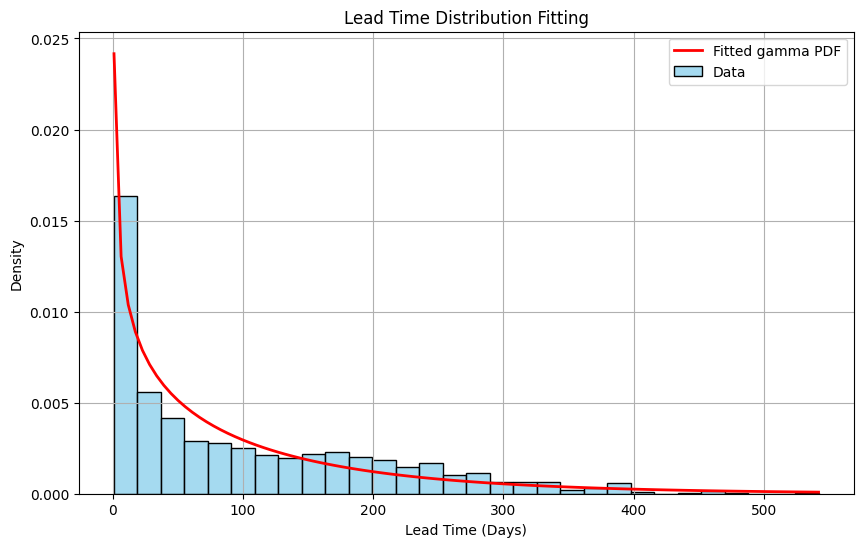

Best Fit for Cancellation Interval: weibull_min with parameters (0.7456975611185204, 0, 47.65408991782711)


/Users/ruicheng/miniconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2441: RuntimeWarning: divide by zero encountered in power
  


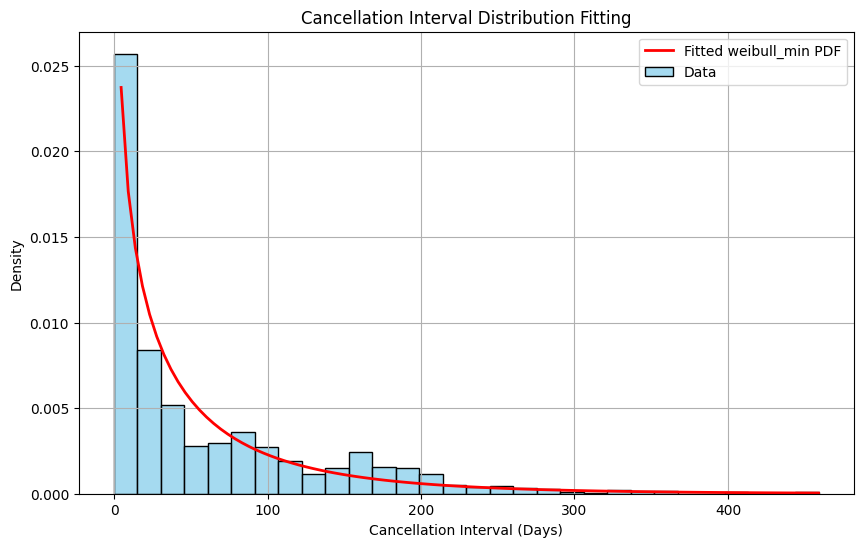

EM converged after 49 iterations.
Poisson Mixture Weights: [0.73591092 0.26408908]
Poisson Mixture Lambdas: [1.28766359 7.07921879]
Grouping counts above 7 into a single bin for Chi-squared test.
Chi-squared Statistic (Walk-in Poisson Mixture): 45.7379
P-value (Walk-in Poisson Mixture): 0.0000


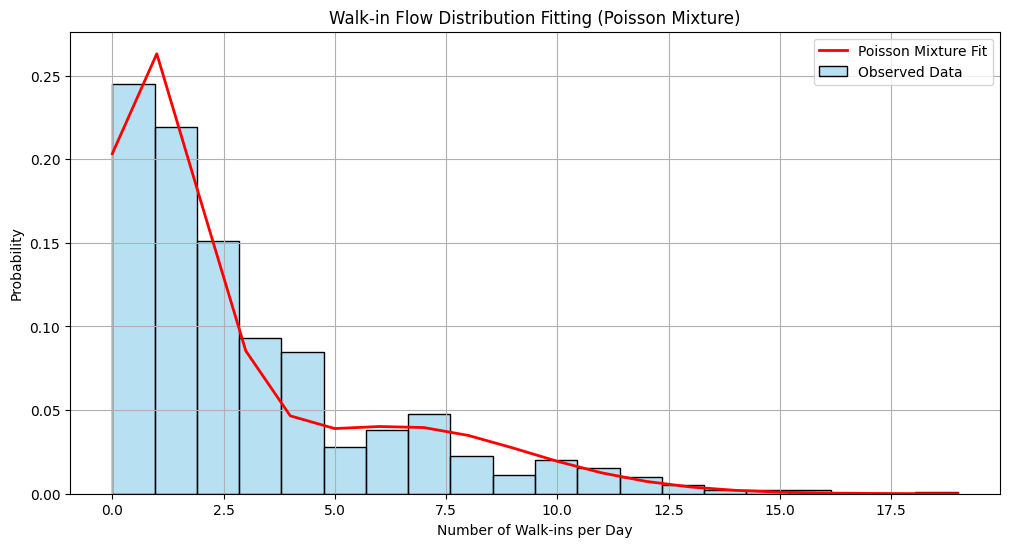

Fitted Geometric p: 0.2939
Grouping occupancy durations above 21 into a single bin for Chi-squared test.
Chi-squared Statistic (Occupancy Geometric): 2515.8646
P-value (Occupancy Geometric): 0.0000


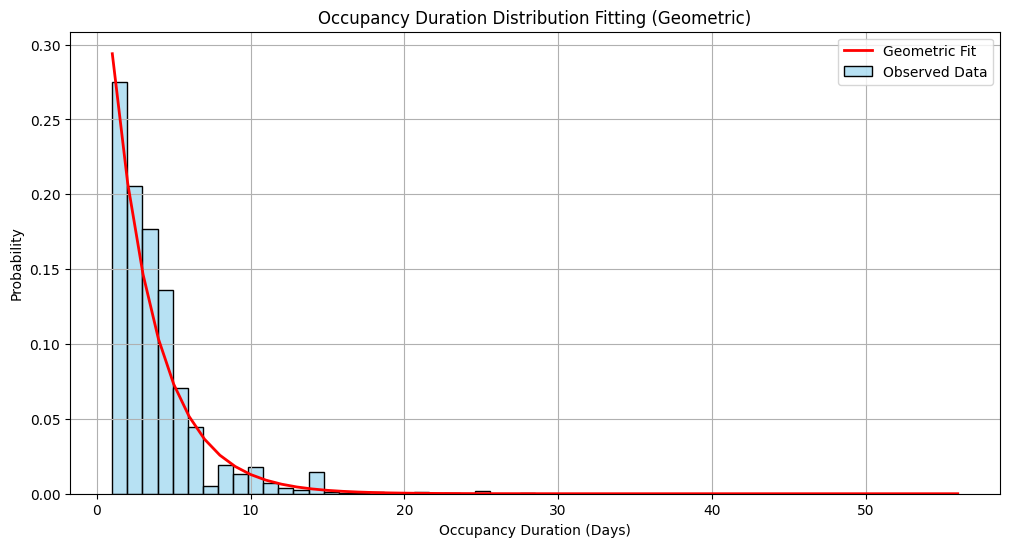

In [103]:
# Cell 1: Fitting Distributions

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Set random seed for reproducibility
np.random.seed(42)

# --------------------------
# 1. Load and Prepare Data
# --------------------------

# Load data from CSV
data = pd.read_csv('type_a_reservations_summary_with_cancel_info_dates.csv')

# Convert relevant columns to datetime
data['Reservation Day'] = pd.to_datetime(data['Reservation Day'])
data['Check-in Day'] = pd.to_datetime(data['Check-in Day'])
data['Cancel_Date'] = pd.to_datetime(data['Cancel_Date'])

# Calculate Lead Times (Check-in Day - Reservation Day)
lead_times = (data['Check-in Day'] - data['Reservation Day']).dt.days.dropna()
lead_times = lead_times[lead_times >= 1]  # Ensure lead times are >=1

# Calculate Cancellation Intervals (Cancel_Date - Reservation Day)
cancellation_intervals = (data['Cancel_Date'] - data['Reservation Day']).dt.days.dropna()
cancellation_intervals = cancellation_intervals[cancellation_intervals >= 0]  # Ensure non-negative

# Extract Occupancy Durations and include d=7
occupancy_durations_all = data['Occupancy_duration'].dropna()
occupancy_durations_all = occupancy_durations_all[occupancy_durations_all > 0].astype(int)

# Exclude d=7 from fitting
occupancy_durations = occupancy_durations_all[occupancy_durations_all != 7]

# Extract Walk-in Flow Data
walkins = data[data['Type_Marked'] == 'Walk-in']
walkins_per_day = walkins.groupby('Check-in Day').size()

# Ensure all days are represented, fill missing days with zero walk-ins
all_days = pd.date_range(start=data['Check-in Day'].min(), end=data['Check-in Day'].max(), freq='D')
walkins_per_day = walkins_per_day.reindex(all_days, fill_value=0)
walkin_counts = walkins_per_day.values

# --------------------------
# 2. Fit Lead Time Distribution
# --------------------------

# Define candidate continuous distributions
continuous_dists = [stats.weibull_min, stats.lognorm, stats.gamma, stats.expon]

# Fit distributions and select best based on AIC
aic_lead = {}
params_lead = {}
for dist in continuous_dists:
    try:
        params = dist.fit(lead_times, floc=0)
        log_likelihood = np.sum(dist.logpdf(lead_times, *params))
        k = len(params)
        aic = 2 * k - 2 * log_likelihood
        aic_lead[dist.name] = aic
        params_lead[dist.name] = params
    except:
        continue

# Select the distribution with the lowest AIC
best_dist_lead = min(aic_lead, key=aic_lead.get)
best_params_lead = params_lead[best_dist_lead]

print(f"Best Fit for Lead Time: {best_dist_lead} with parameters {best_params_lead}")

# Plot Lead Time Fit
plt.figure(figsize=(10,6))
sns.histplot(lead_times, bins=30, kde=False, color='skyblue', stat='density', label='Data', edgecolor='black')
x = np.linspace(lead_times.min(), lead_times.max(), 100)
pdf_fitted = getattr(stats, best_dist_lead).pdf(x, *best_params_lead)
plt.plot(x, pdf_fitted, 'r-', label=f'Fitted {best_dist_lead} PDF', linewidth=2)
plt.xlabel('Lead Time (Days)')
plt.ylabel('Density')
plt.title('Lead Time Distribution Fitting')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# 3. Fit Cancellation Interval Distribution
# --------------------------

# Fit distributions and select best based on AIC
aic_cancel = {}
params_cancel = {}
for dist in continuous_dists:
    try:
        params = dist.fit(cancellation_intervals, floc=0)
        log_likelihood = np.sum(dist.logpdf(cancellation_intervals, *params))
        k = len(params)
        aic = 2 * k - 2 * log_likelihood
        aic_cancel[dist.name] = aic
        params_cancel[dist.name] = params
    except:
        continue

# Select the distribution with the lowest AIC
best_dist_cancel = min(aic_cancel, key=aic_cancel.get)
best_params_cancel = params_cancel[best_dist_cancel]

print(f"Best Fit for Cancellation Interval: {best_dist_cancel} with parameters {best_params_cancel}")

# Plot Cancellation Interval Fit
plt.figure(figsize=(10,6))
sns.histplot(cancellation_intervals, bins=30, kde=False, color='skyblue', stat='density', label='Data', edgecolor='black')
x = np.linspace(cancellation_intervals.min(), cancellation_intervals.max(), 100)
pdf_fitted = getattr(stats, best_dist_cancel).pdf(x, *best_params_cancel)
plt.plot(x, pdf_fitted, 'r-', label=f'Fitted {best_dist_cancel} PDF', linewidth=2)
plt.xlabel('Cancellation Interval (Days)')
plt.ylabel('Density')
plt.title('Cancellation Interval Distribution Fitting')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# 4. Fit Walk-in Flow with Mixture of Poisson Distributions
# --------------------------

# Define EM algorithm for Poisson Mixture
def poisson_mixture_em(data, K=2, max_iter=1000, tol=1e-6):
    N = len(data)
    weights = np.full(K, 1/K)
    lambdas = np.random.uniform(1, np.mean(data)*2, K)
    
    for iteration in range(max_iter):
        # E-step
        responsibilities = np.zeros((N, K))
        for k in range(K):
            responsibilities[:, k] = weights[k] * stats.poisson.pmf(data, mu=lambdas[k])
        sum_responsibilities = responsibilities.sum(axis=1, keepdims=True)
        sum_responsibilities[sum_responsibilities == 0] = 1e-10  # Prevent division by zero
        responsibilities /= sum_responsibilities
        
        # M-step
        weights_new = responsibilities.mean(axis=0)
        lambdas_new = (responsibilities * data[:, np.newaxis]).sum(axis=0) / responsibilities.sum(axis=0)
        
        # Check convergence
        if np.all(np.abs(weights_new - weights) < tol) and np.all(np.abs(lambdas_new - lambdas) < tol):
            print(f"EM converged after {iteration+1} iterations.")
            break
        
        weights, lambdas = weights_new, lambdas_new
    
    return weights, lambdas

# Fit Poisson Mixture
weights_walkin, lambdas_walkin = poisson_mixture_em(walkin_counts, K=2)

print(f"Poisson Mixture Weights: {weights_walkin}")
print(f"Poisson Mixture Lambdas: {lambdas_walkin}")

# Calculate expected probabilities
x_walkin = np.arange(0, walkin_counts.max()+1)
pmf_walkin_1 = stats.poisson.pmf(x_walkin, mu=lambdas_walkin[0])
pmf_walkin_2 = stats.poisson.pmf(x_walkin, mu=lambdas_walkin[1])
pmf_mixture_walkin = weights_walkin[0] * pmf_walkin_1 + weights_walkin[1] * pmf_walkin_2

# Calculate observed frequencies
observed_counts_walkin = np.bincount(walkin_counts, minlength=walkin_counts.max()+1)

# Determine max_count_walkin for Chi-squared test
def determine_max_count_poisson(lambda_poisson, threshold=5, max_possible=None):
    if max_possible is None:
        max_possible = np.max(walkin_counts)
    x = 0
    while x <= max_possible:
        expected = stats.poisson.pmf(x, mu=lambda_poisson) * len(walkin_counts)
        if expected < threshold:
            break
        x += 1
    return x-1 if x > 0 else x

max_count_walkin = determine_max_count_poisson(np.mean(walkin_counts))
print(f"Grouping counts above {max_count_walkin} into a single bin for Chi-squared test.")

# Group counts above max_count_walkin
observed_grouped_walkin = np.concatenate([
    observed_counts_walkin[:max_count_walkin+1],
    [observed_counts_walkin[max_count_walkin+1:].sum()]
])

# Group expected counts
expected_probs_walkin = pmf_mixture_walkin
expected_probs_walkin = expected_probs_walkin[:max_count_walkin+1].tolist()
expected_probs_walkin.append(pmf_mixture_walkin[max_count_walkin+1:].sum())
expected_counts_walkin = np.array(expected_probs_walkin) * len(walkin_counts)

# Adjust expected counts to exactly match observed counts
difference_walkin = len(walkin_counts) - expected_counts_walkin.sum()
expected_counts_walkin[-1] += difference_walkin

# Perform Chi-squared test
chi2_stat_walkin, p_value_walkin = stats.chisquare(f_obs=observed_grouped_walkin, f_exp=expected_counts_walkin)
print(f"Chi-squared Statistic (Walk-in Poisson Mixture): {chi2_stat_walkin:.4f}")
print(f"P-value (Walk-in Poisson Mixture): {p_value_walkin:.4f}")

# Plot Walk-in Flow Fit (Smoothed)
plt.figure(figsize=(12,6))
sns.histplot(walkin_counts, bins=walkin_counts.max()+1, stat='probability', color='skyblue', label='Observed Data', kde=False, edgecolor='black', alpha=0.6)
plt.plot(x_walkin, pmf_mixture_walkin, 'r-', linewidth=2, label='Poisson Mixture Fit')
plt.xlabel('Number of Walk-ins per Day')
plt.ylabel('Probability')
plt.title('Walk-in Flow Distribution Fitting (Poisson Mixture)')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# 5. Fit Occupancy Duration with Geometric Distribution and Replace d=7
# --------------------------

# Fit Geometric distribution manually (exclude d=7)
p_geometric = 1 / np.mean(occupancy_durations)
print(f"Fitted Geometric p: {p_geometric:.4f}")

# Identify indices with d=7
indices_d7 = occupancy_durations_all[occupancy_durations_all ==7].index
num_d7 = len(indices_d7)

# Generate new data for d=7 using Geometric distribution
new_durations = stats.geom.rvs(p=p_geometric, size=num_d7)

# Replace d=7 with new durations
occupancy_durations_all.loc[indices_d7] = new_durations

# Calculate expected probabilities with replaced d=7
x_duration = np.arange(1, occupancy_durations_all.max()+1)
pmf_geometric_full = stats.geom.pmf(x_duration, p=p_geometric)

# Calculate observed frequencies
observed_counts_duration = np.bincount(occupancy_durations_all, minlength=occupancy_durations_all.max()+1)[1:]

# Calculate expected counts
expected_probs_geometric = stats.geom.pmf(x_duration, p=p_geometric)
expected_counts_geometric = expected_probs_geometric * len(occupancy_durations_all)

# Determine max_count_duration for Chi-squared test
def determine_max_count_geometric(p, threshold=5, max_possible=None):
    if max_possible is None:
        max_possible = len(x_duration)
    x = 1
    while x <= max_possible:
        expected = stats.geom.pmf(x, p=p) * len(occupancy_durations_all)
        if expected < threshold:
            break
        x += 1
    return x-1 if x >1 else x

max_count_duration = determine_max_count_geometric(p_geometric, threshold=5, max_possible=occupancy_durations_all.max())
print(f"Grouping occupancy durations above {max_count_duration} into a single bin for Chi-squared test.")

# Group counts above max_count_duration
observed_grouped_duration = np.concatenate([
    observed_counts_duration[:max_count_duration],
    [observed_counts_duration[max_count_duration:].sum()]
])
expected_grouped_duration = np.concatenate([
    expected_counts_geometric[:max_count_duration],
    [expected_counts_geometric[max_count_duration:].sum()]
])

# Adjust expected counts to exactly match observed counts
difference_duration = len(occupancy_durations_all) - expected_grouped_duration.sum()
expected_grouped_duration[-1] += difference_duration

# Perform Chi-squared test
chi2_stat_duration, p_value_duration = stats.chisquare(f_obs=observed_grouped_duration, f_exp=expected_grouped_duration)
print(f"Chi-squared Statistic (Occupancy Geometric): {chi2_stat_duration:.4f}")
print(f"P-value (Occupancy Geometric): {p_value_duration:.4f}")

# Plot Occupancy Duration Fit with d=7 replaced by fitted value
plt.figure(figsize=(12,6))
sns.histplot(occupancy_durations_all, bins=occupancy_durations_all.max(), stat='probability', color='skyblue', label='Observed Data', kde=False, edgecolor='black', alpha=0.6)
plt.plot(x_duration, pmf_geometric_full, 'r-', linewidth=2, label='Geometric Fit')
plt.xlabel('Occupancy Duration (Days)')
plt.ylabel('Probability')
plt.title('Occupancy Duration Distribution Fitting (Geometric)')
plt.legend()
plt.grid(True)
plt.show()


In [109]:
import numpy as np
import pandas as pd
from scipy import stats
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 1. Load Fitted Parameters
# --------------------------

# Ensure that Cell 1 has been run successfully before executing Cell 2.
# Variables from Cell 1 required:
# - best_dist_lead, best_params_lead
# - best_dist_cancel, best_params_cancel
# - weights_walkin, lambdas_walkin
# - p_geometric

# --------------------------
# 2. Define Simulation Parameters
# --------------------------

# Parameters for fine-tuning
lambda1 = 5      # Expected number of reservations per day
p = 0.1          # Probability of cancellation in reservation stage
p_0 = 0.05       # Probability of cancellation in check-in stage
lambda2 = 1.0    # Scaling factor for walk-ins

# Validate probabilities
if p + p_0 > 1:
    raise ValueError("The sum of p and p_0 should not exceed 1.")

# --------------------------
# 3. Adjust Walk-in Parameters
# --------------------------

# Scale the means of the Poisson mixture components for walk-ins by lambda2
lambdas_walkin_scaled = lambdas_walkin * lambda2

# --------------------------
# 4. Generate Reservation Information (Including Reservations and Walk-ins)
# --------------------------

# Define simulation period
simulation_start = pd.to_datetime('2023-01-01')
simulation_end = simulation_start + pd.DateOffset(years=3) - pd.DateOffset(days=1)
simulation_days = pd.date_range(start=simulation_start, end=simulation_end, freq='D')

# Initialize list to collect simulated data
simulated_data = []

# Function to sample walk-in counts using Poisson Mi


In [115]:
import numpy as np
import pandas as pd
from scipy import stats
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 1. Load Fitted Parameters
# --------------------------

# Ensure that Cell 1 has been run successfully before executing Cell 2.
# Variables from Cell 1 required:
# - best_dist_lead, best_params_lead
# - best_dist_cancel, best_params_cancel
# - weights_walkin, lambdas_walkin
# - p_geometric

# --------------------------
# 2. Define Simulation Parameters
# --------------------------

# Parameters for fine-tuning
lambda1 = 30      # Expected number of reservations per day
p = 0.1          # Probability of cancellation in reservation stage
p_0 = 0.05       # Probability of cancellation in check-in stage
lambda2 = 10    # Scaling factor for walk-ins

# Validate probabilities
if p + p_0 > 1:
    raise ValueError("The sum of p and p_0 should not exceed 1.")

# --------------------------
# 3. Adjust Walk-in Parameters
# --------------------------

# Scale the means of the Poisson mixture components for walk-ins by lambda2
lambdas_walkin_scaled = lambdas_walkin * lambda2

# --------------------------
# 4. Generate Reservation Information (Including Reservations and Walk-ins)
# --------------------------

# Define simulation period
simulation_start = pd.to_datetime('2023-01-01')
simulation_end = simulation_start + pd.DateOffset(years=3) - pd.DateOffset(days=1)
simulation_days = pd.date_range(start=simulation_start, end=simulation_end, freq='D')

# Initialize list to collect simulated data
simulated_data = []

# Function to sample walk-in counts using Poisson Mixture
def generate_walkin_counts(size=1):
    components = np.random.choice(len(weights_walkin), size=size, p=weights_walkin)
    samples = stats.poisson.rvs(mu=lambdas_walkin_scaled[components], size=size)
    return samples

# Function to sample occupancy durations using Geometric
def generate_occupancy_duration(size=1):
    samples = stats.geom.rvs(p=p_geometric, size=size)
    # Replace d=7 with fitted Geometric samples to hide abnormality
    replace_indices = np.where(samples ==7)[0]
    if len(replace_indices) >0:
        samples[replace_indices] = stats.geom.rvs(p=p_geometric, size=len(replace_indices))
    return samples

# Function to sample lead times from truncated distribution
def generate_lead_time(size=1, max_lead_time=365):
    # Truncate the lead time distribution at 1 and max_lead_time
    dist = getattr(stats, best_dist_lead)
    a, b = (1 - best_params_lead[1]) / best_params_lead[2], (max_lead_time - best_params_lead[1]) / best_params_lead[2]
    samples = dist.rvs(*best_params_lead, size=size)
    samples = np.clip(samples, 1, max_lead_time)
    samples = samples.astype(int)
    return samples

# Function to sample cancellation intervals from conditional distribution
def generate_cancellation_interval(lead_time):
    max_cancel_interval = lead_time - 1
    dist = getattr(stats, best_dist_cancel)
    a, b = (0 - best_params_cancel[1]) / best_params_cancel[2], (max_cancel_interval - best_params_cancel[1]) / best_params_cancel[2]
    # Sample from the truncated distribution
    cancel_interval = dist.rvs(*best_params_cancel, size=1)
    cancel_interval = np.clip(cancel_interval, 0, max_cancel_interval)
    cancel_interval = cancel_interval.astype(int)
    return cancel_interval[0]

# Iterate over each day in simulation period
for current_day in simulation_days:
    # Simulate Walk-ins
    num_walkins = generate_walkin_counts(size=1)[0]
    num_walkins = int(num_walkins)  # Convert to int
    for _ in range(num_walkins):
        occupancy_duration = generate_occupancy_duration(size=1)[0]
        occupancy_duration = int(occupancy_duration)  # Convert to int
        simulated_data.append({
            'Reservation Day': current_day,
            'Check-in Day': current_day,
            'Occupancy_duration': occupancy_duration,
            'Decision': 'Confirmed',
            'Cancel_Date': pd.NaT,
            'Type_Marked': 'Walk-in',
            'Lead_Time': 0
        })
    
    # Simulate Reservations
    # Number of reservations per day follows Poisson(lambda1)
    num_reservations = stats.poisson.rvs(mu=lambda1, size=1)[0]
    num_reservations = int(num_reservations)  # Convert to int
    for _ in range(num_reservations):
        # Sample lead time from truncated distribution
        lead_time = generate_lead_time(size=1)[0]
        lead_time = int(lead_time)  # Convert to int
        check_in_day = current_day + timedelta(days=lead_time)
        occupancy_duration = generate_occupancy_duration(size=1)[0]
        occupancy_duration = int(occupancy_duration)  # Convert to int
        
        # Determine cancellation status
        rand_prob = np.random.rand()
        if rand_prob < p:
            # Cancel in reservation stage
            decision = 'Cancel in reservation stage'
            # Sample cancellation interval
            cancel_interval = generate_cancellation_interval(lead_time)
            cancel_interval = int(cancel_interval)  # Convert to int
            cancel_date = current_day + timedelta(days=cancel_interval)
        elif rand_prob < p + p_0:
            # Cancel in check-in stage
            decision = 'Cancel in check-in stage'
            cancel_interval = lead_time
            cancel_interval = int(cancel_interval)  # Convert to int
            cancel_date = current_day + timedelta(days=cancel_interval)
        else:
            # Confirmed reservation
            decision = 'Confirmed'
            cancel_interval = np.NaN
            cancel_date = pd.NaT
        
        simulated_data.append({
            'Reservation Day': current_day,
            'Check-in Day': check_in_day,
            'Occupancy_duration': occupancy_duration,
            'Decision': decision,
            'Cancel_Date': cancel_date,
            'Type_Marked': 'Reservation',
            'Lead_Time': lead_time
        })

# Create DataFrame from simulated data
simulated_df = pd.DataFrame(simulated_data)

# Ensure correct data types
simulated_df['Reservation Day'] = pd.to_datetime(simulated_df['Reservation Day'])
simulated_df['Check-in Day'] = pd.to_datetime(simulated_df['Check-in Day'])
simulated_df['Cancel_Date'] = pd.to_datetime(simulated_df['Cancel_Date'])

# Save the reservation information to CSV
simulated_df.to_csv('simulated_three_year.csv', index=False)
print("Reservation information simulation complete. Data saved to 'simulated_three_year.csv'.")


Reservation information simulation complete. Data saved to 'simulated_three_year.csv'.


In [116]:
# --------------------------
# 5. Generate Daily Summary Separately
# --------------------------

# Load the simulated reservation data
simulated_df = pd.read_csv('simulated_three_year.csv')

# Convert date columns to datetime
simulated_df['Reservation Day'] = pd.to_datetime(simulated_df['Reservation Day'])
simulated_df['Check-in Day'] = pd.to_datetime(simulated_df['Check-in Day'])
simulated_df['Cancel_Date'] = pd.to_datetime(simulated_df['Cancel_Date'])

# Define simulation period
simulation_days = pd.date_range(start=simulation_start, end=simulation_end, freq='D')

# Initialize DataFrame for daily aggregation
daily_summary = pd.DataFrame({
    'Date': simulation_days
})
daily_summary.set_index('Date', inplace=True)

# Total Reservations per Day
reservations = simulated_df[simulated_df['Type_Marked'] == 'Reservation']
reservations_per_day = reservations.groupby('Reservation Day').size()
daily_summary['Total_Reservations'] = reservations_per_day

# Total Walk-ins per Day
walkins = simulated_df[simulated_df['Type_Marked'] == 'Walk-in']
walkins_per_day = walkins.groupby('Check-in Day').size()
daily_summary['Total_Walkins'] = walkins_per_day

# Total Canceled Reservations per Day
cancellations = reservations[reservations['Decision'].str.contains('Cancel')]
cancellations_per_day = cancellations.groupby('Cancel_Date').size()
daily_summary['Total_Cancellations'] = cancellations_per_day

# Replace NaN with 0
daily_summary.fillna(0, inplace=True)

# Ensure integer counts
daily_summary['Total_Reservations'] = daily_summary['Total_Reservations'].astype(int)
daily_summary['Total_Walkins'] = daily_summary['Total_Walkins'].astype(int)
daily_summary['Total_Cancellations'] = daily_summary['Total_Cancellations'].astype(int)

# --------------------------
# 6. Calculate Total Occupied Rooms per Day
# --------------------------

# Filter active arrivals (Confirmed Reservations and Walk-ins)
active_reservations = reservations[reservations['Decision'] == 'Confirmed']
active_walkins = walkins.copy()  # All walk-ins are confirmed

# Combine active reservations and walk-ins
active_arrivals = pd.concat([active_reservations, active_walkins], ignore_index=True)

# Calculate Check-out Day for each arrival
active_arrivals['Check-out Day'] = active_arrivals['Check-in Day'] + pd.to_timedelta(active_arrivals['Occupancy_duration'], unit='D')

# Initialize a Series to hold occupied rooms count
occupied_rooms = pd.Series(0, index=simulation_days)

# Iterate over each arrival and mark occupancy
for _, row in active_arrivals.iterrows():
    check_in = row['Check-in Day']
    check_out = row['Check-out Day']
    # Ensure the check-out day does not exceed simulation period
    check_out = min(check_out, simulation_end + timedelta(days=1))
    # Increment occupancy for each day of stay
    if check_in < simulation_start:
        check_in = simulation_start
    if check_out > simulation_end + timedelta(days=1):
        check_out = simulation_end + timedelta(days=1)
    occupied_rooms.loc[check_in:check_out - timedelta(days=1)] += 1

# Add the occupied rooms to the daily_summary DataFrame
daily_summary['Total_Occupied_Rooms'] = occupied_rooms.values

# Reset index to have 'Date' as a column
daily_summary.reset_index(inplace=True)

# --------------------------
# 7. Save Aggregated Daily Data
# --------------------------

# Save to CSV
daily_summary.to_csv('simulated_three_year_day.csv', index=False)

print("Daily summary generation complete. Data saved to 'simulated_three_year_day.csv'.")


Daily summary generation complete. Data saved to 'simulated_three_year_day.csv'.
